### Import packages & initialization

In [2]:
!pip3 install wandb

In [3]:
from google.colab import drive
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from skimage.io import imread
import numpy as np
import torch
from functools import lru_cache, partial
from itertools import repeat
from multiprocessing import Pool
from os import listdir
from os.path import splitext, isfile, join
from pathlib import Path
from torch.utils.data import Dataset
from tqdm import tqdm
import torch.nn.functional as F
from tqdm import tqdm
import argparse
import logging
import random
import sys
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim
from torch.utils.data import DataLoader, random_split, Subset
import wandb
from PIL import Image
import re
from shutil import copyfile
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/My Drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Functions used in this notebook

All of the written functions are also stored in functions.py file. However, it was decided to write them here as well in order for the notebook to be read easier.

For defining the different paths like images & labels:

In [4]:
def set_paths(drive_path = 'drive/MyDrive/Deep_Learning_Project_28/training_dataset/') :

    image_paths = sorted(glob.glob(drive_path + "data/*.tiff"))
    label_paths = sorted(glob.glob(drive_path + "labels/*.tif"))
    dir_img = drive_path + 'data/'
    dir_mask = drive_path + 'labels/'
    dir_checkpoint = Path('./checkpoints/')
    print("Total Observations:\t", 'images', len(image_paths), ', labels', len(label_paths))

    return image_paths, label_paths, dir_img, dir_mask, dir_checkpoint


For getting the pixels of an image:

In [5]:
def get_pixels(image_path):
    # Open the image using PIL
    image = Image.open(image_path)

    # Convert the image to a NumPy array
    np_array = np.array(image, dtype=np.float32)

    # Convert the NumPy array to a PyTorch tensor
    tensor_image = torch.from_numpy(np_array)

    # Flatten the tensor to get the pixel values
    flattened_pixels = tensor_image.view(-1)

    return flattened_pixels

For adding Gaussian noise to an image:

In [6]:
def add_gaussian_noise(image, mean=0, std=25):
    """
    Add Gaussian noise to the given image.

    Parameters:
    - image: Input image (PIL Image or NumPy array).
    - mean: Mean of the Gaussian noise.
    - std: Standard deviation of the Gaussian noise.

    Returns:
    - Image with added Gaussian noise.
    """
    if isinstance(image, Image.Image):
        image = np.array(image)

    # Generate Gaussian noise
    noise = np.random.normal(mean, std, image.shape)

    # Add noise to the image
    noisy_image = image + noise

    # Clip pixel values to the valid 16-bit range [0, 65535]
    noisy_image = np.clip(noisy_image, 0, 65535)

    # Convert back to uint8 if necessary
    if noisy_image.dtype == np.float32:
        noisy_image = noisy_image.astype(np.uint8)

    if isinstance(image, Image.Image):
        return Image.fromarray(noisy_image)
    else:
        return noisy_image


For adding the Gaussian noise to all the images in the path. It uses the function "add_gaussian_noise" inside:

In [7]:
def add_noisy_images(drive_path = 'drive/MyDrive/Deep_Learning_Project_28/training_dataset/',n=100,std=5000):

    input_folder_path = drive_path + "data/"
    input_folder_labels_path = drive_path + "labels/"
    # List all files in the input directory
    file_list = os.listdir(input_folder_path)

    # Randomly select n images
    selected_files = np.random.choice(file_list, n, replace=False)

    # Iterate through the selected files and add Gaussian noise

    image_num = 501

    for file_name in selected_files:
        if file_name.endswith(".tiff") or file_name.endswith(".tif"):

            # Construct the full path to the input image
            input_image_path = os.path.join(input_folder_path, file_name)

            # Open the original image
            original_image = Image.open(input_image_path)

            # Add Gaussian noise
            noisy_image = add_gaussian_noise(original_image, mean=0, std=std)

            # Convert the NumPy array back to a PIL Image
            noisy_image_pil = Image.fromarray(noisy_image)

            # Construct the full path to the output image
            noisy_data_name = "SOCprist0"+ str(image_num)+".tiff"
            output_image_path = os.path.join(input_folder_path,noisy_data_name)


            # Save the noisy image
            noisy_image_pil.save(output_image_path)

            # Add labels to label folder
            original_label_path = input_folder_labels_path+ 'slice__'+file_name[-8:-5]+'.tif'
            noisy_label_name = 'slice__'+str(image_num)+'.tif'
            noisy_label_path = os.path.join(input_folder_labels_path, noisy_label_name)

            # Copy the original label file to the new label file
            copyfile(original_label_path, noisy_label_path)


            image_num = image_num + 1

    print(f"Noisy images saved to {input_folder_path}")

For deleting the already made noisy images (in order for the code to be reproducible):

In [8]:
def delete_noisy_images(folder_path):
    """
    Delete all files which have the number above 500 in the specified folder.

    Parameters:
    - folder_path: Path to the folder containing the noisy images.
    """
    file_list = os.listdir(folder_path)
    for file_name in file_list:
        match = re.search(r'(\d{3})\.(?:tiff|tif)', file_name)
        three_digits = match.group(1)

        if int(three_digits)>500:
            file_path = os.path.join(folder_path, file_name)
            os.remove(file_path)


For adding again the already removed prefix to the images (in order for the code to be reproducible):

In [9]:
def add_prefix_to_files(drive_path = 'drive/MyDrive/Deep_Learning_Project_28/training_dataset/' , prefix ="slice__"):
    """
    Add a prefix to the beginning of all files in the specified folder.

    Parameters:
    - folder_path: Path to the folder containing the files.
    - prefix: The prefix to add to each filename.
    """

    folder_path =drive_path + "labels/"
    # List all files in the folder
    file_list = os.listdir(folder_path)

    for file_name in file_list:
        # Construct the full path to the file
        file_path = os.path.join(folder_path, file_name)

        # Construct the new filename with the added prefix
        new_file_name = prefix + file_name

        # Construct the full path to the new file
        new_file_path = os.path.join(folder_path, new_file_name)

        # Rename the file with the new filename
        os.rename(file_path, new_file_path)



For renaming the images to be able to be passed to the model:

In [10]:
def rename_images(image_paths,drive_path ):
    for index, path in enumerate(image_paths):
        id = splitext(path)[0][-3:]
        print(splitext(path)[0][-3:])
        print(drive_path + "data/" + id + ".tiff")
        os.rename(path, drive_path + "data/" + id + ".tiff")

For renaming the labels to be able to be passed to the model:

In [11]:
def rename_labels(label_paths,drive_path ):
    for index, path in enumerate(label_paths):
        id = splitext(path)[0][-3:]
        print(splitext(path)[0][-3:])
        print(drive_path + "labels/" + id + ".tif")
        os.rename(path, drive_path + "labels/" + id + ".tif")

For better understanding of the main work in this notebook, the rest of the function are placed in the additional .py file called functions.py

In [12]:
import functions
#from functions import set_paths, get_pixels, add_gaussian_noise, delete_noisy_images, add_noisy_images, add_prefix_to_files, rename_images, rename_labels
from functions import  UNet, get_args, train_model

In [13]:
drive_path =  'drive/MyDrive/Deep_Learning_Project_28/training_dataset/'
image_paths, label_paths, dir_img, dir_mask, dir_checkpoint = set_paths(drive_path=drive_path)

Total Observations:	 images 600 , labels 600


## Working Around

### Get Pixels

To get a better sense about the range for the pixels in order to add the Gaussian noise with a proper standard deviation.

In [14]:
image_path = drive_path + "data/001.tiff" # original dataset

pixels = get_pixels(image_path)

# Print the pixel values
print(min(pixels),torch.mean(pixels),max(pixels))

tensor(18465.) tensor(32907.8359) tensor(44477.)


### Visualization

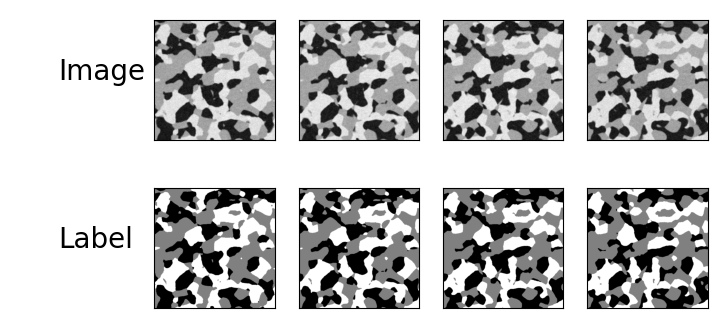

In [15]:
# Display the first image and its segmentation
f, axarr = plt.subplots(2, 5, subplot_kw={'xticks': [], 'yticks': []}, figsize=(9, 4))

axarr[0,0].text(0.4, 0.5, 'Image', fontsize=20)
axarr[0,0].axis('off')
axarr[0,0].set_clip_on(False)


axarr[1,0].text(0.4, 0.5, 'Label', fontsize=20)
axarr[1,0].axis('off')
axarr[1,0].set_clip_on(False)

for i in range(4):
  image = imread(image_paths[i*4], as_gray=True)
  axarr[0,i+1].imshow(image, cmap='gray')

  label = imread(label_paths[i*4], as_gray=True)
  axarr[1,i+1].imshow(label, cmap='gray')

plt.show()

### Example of a Noisy Image

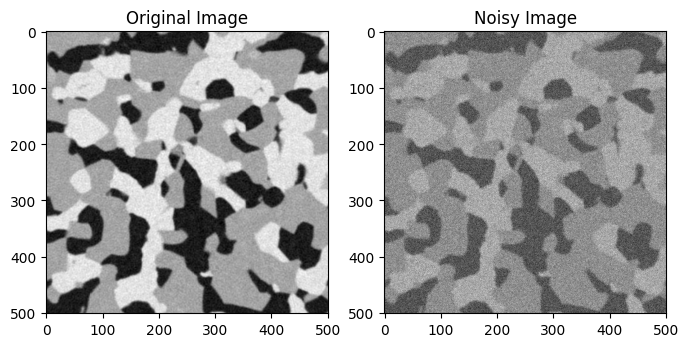

In [16]:
std = 5000

#image_path = drive_path + "data/SOCprist0081.tiff"
image_path = drive_path + "data/081.tiff"
original_image = Image.open(image_path)

# Add Gaussian noise
noisy_image = add_gaussian_noise(original_image, mean=0, std=std)

# Display original and noisy images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')


# Save the figure
plt.savefig(drive_path+'original_and_noisy_images_compare.png')

plt.show()

# Convert the image to a NumPy array
np_array = np.array(noisy_image, dtype=np.float32)

# Convert the NumPy array to a PyTorch tensor
tensor_image = torch.from_numpy(np_array)

# Flatten the tensor to get the pixel values
flattened_pixels = tensor_image.view(-1)

### Class encoding

From the label images of the previous cell we see that the classes are encoded as grayscale images of three shades.

This means there is one color channel, no third dimension.

In [17]:
label = imread(label_paths[0], as_gray=True)
print(label.shape)

(501, 501)


 And three pixel values (0, 128, 255).

In [18]:
unique, counts = np.unique(label, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 79317]
 [  128 89810]
 [  255 81874]]


## Noisy Images

### Delete Noisy Images

In [19]:
output_folder_path = drive_path + "data/"
delete_noisy_images(output_folder_path)
print(f"Noisy images in {output_folder_path} deleted.")


output_folder_path = drive_path + "labels/"
delete_noisy_images(output_folder_path)
print(f"Noisy images in {output_folder_path} deleted.")

Noisy images in drive/MyDrive/Deep_Learning_Project_28/training_dataset/data/ deleted.
Noisy images in drive/MyDrive/Deep_Learning_Project_28/training_dataset/labels/ deleted.


### Add Prefix
(This is used if one wants to get the original names of the labels)

In [20]:
prefix = "slice__"

add_prefix_to_files(drive_path , prefix)

### Add Noisy Images

In [21]:
add_noisy_images(drive_path = drive_path,n=100,std=5000)

Noisy images saved to drive/MyDrive/Deep_Learning_Project_28/training_dataset/data/


## Preprocessing

### Rename images

In [22]:
image_paths, label_paths, dir_img, dir_mask, dir_checkpoint = set_paths(drive_path=drive_path)

Total Observations:	 images 600 , labels 600


In [24]:
rename_images(image_paths = image_paths,drive_path = drive_path)
rename_labels(label_paths = label_paths,drive_path =drive_path)

In [25]:
image_paths, label_paths, dir_img, dir_mask, dir_checkpoint = set_paths(drive_path=drive_path)

Total Observations:	 images 600 , labels 600


## Train the model

### Experiment 2: Noisy Images Addition

Train the model on a combination of original and noisy images (540 images) and evaluate its
performance on the original and noisy validation dataset  (60 images)

In [27]:
class ArgsBypass:
  epochs  = 5
  batch_size  = 1
  lr = 1e-5
  load = False
  scale = 1
  val = 10.0
  amp = False
  bilinear = False
  classes = 3
  pass

args = ArgsBypass()

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
# model = UNet(n_channels=3, n_classes=args.classes, bilinear=args.bilinear)
model = UNet(n_channels=1, n_classes=args.classes, bilinear=args.bilinear)
model = model.to(memory_format=torch.channels_last)

logging.info(f'Network:\n'
              f'\t{model.n_channels} input channels\n'
              f'\t{model.n_classes} output channels (classes)\n'
              f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

if args.load:
    state_dict = torch.load(args.load, map_location=device)
    del state_dict['mask_values']
    model.load_state_dict(state_dict)
    logging.info(f'Model loaded from {args.load}')

model.to(device=device)
try:
    train_model(
        model=model,
        dir_img=dir_img,
        dir_mask=dir_mask,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        device=device,
        img_scale=args.scale,
        val_percent=args.val / 100,
        amp=args.amp,
        split_type = 'random_split'
    )
except torch.cuda.OutOfMemoryError:
    logging.error('Detected OutOfMemoryError! '
                  'Enabling checkpointing to reduce memory usage, but this slows down training. '
                  'Consider enabling AMP (--amp) for fast and memory efficient training')
    torch.cuda.empty_cache()
    model.use_checkpointing()
    train_model(
        model=model,
        dir_img=dir_img,
        dir_mask=dir_mask,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        device=device,
        img_scale=args.scale,
        val_percent=args.val / 100,
        amp=args.amp,
        split_type = 'random_split'
    )

### Experiment 3: Noisy Images Only in Validation

Train the model on the original training dataset (440 images) but validate on a dataset containing
original and noisy images. (60+60 images)

In [29]:
class ArgsBypass:
  epochs  = 5
  batch_size  = 1
  lr = 1e-5
  load = False
  scale = 1
  val = 20.0
  amp = False
  bilinear = False
  classes = 3
  pass

args = ArgsBypass()

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
# model = UNet(n_channels=3, n_classes=args.classes, bilinear=args.bilinear)
model = UNet(n_channels=1, n_classes=args.classes, bilinear=args.bilinear)
model = model.to(memory_format=torch.channels_last)

logging.info(f'Network:\n'
              f'\t{model.n_channels} input channels\n'
              f'\t{model.n_classes} output channels (classes)\n'
              f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

if args.load:
    state_dict = torch.load(args.load, map_location=device)
    del state_dict['mask_values']
    model.load_state_dict(state_dict)
    logging.info(f'Model loaded from {args.load}')

model.to(device=device)
try:
    train_model(
        model=model,
        dir_img=dir_img,
        dir_mask=dir_mask,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        device=device,
        img_scale=args.scale,
        val_percent=args.val / 100,
        amp=args.amp,
        val_original_percent = 0.5,
        split_type = 'split_noisy_after_training'
    )
except torch.cuda.OutOfMemoryError:
    logging.error('Detected OutOfMemoryError! '
                  'Enabling checkpointing to reduce memory usage, but this slows down training. '
                  'Consider enabling AMP (--amp) for fast and memory efficient training')
    torch.cuda.empty_cache()
    model.use_checkpointing()
    train_model(
        model=model,
        dir_img=dir_img,
        dir_mask=dir_mask,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        device=device,
        img_scale=args.scale,
        val_percent=args.val / 100,
        amp=args.amp,
        val_original_percent=0.5,
        split_type = 'split_noisy_after_training'
    )